<img src="resources/header.png"/>

# Predictive modeling on a dataset of Earth satellites in BayesDB

Authored by: [Feras Saad](http://fsaad.mit.edu) of the MIT Probabilistic Computing Project (Probcomp). Prepared for: The DARPA PPAML PI meeting, July 2017.

In this notebook, we are going to use BayesDB for predictive modeling on a [database of Earth satellites](http://www.ucsusa.org/nuclear-weapons/space-weapons/satellite-database#.V9bJf7krKkA) from the Union of Concerned Scientists. This dataset contains over 1100 earth satellites, and their kinematic, material, electrical, political, functional, and economic characteristics. We will build CrossCat models of the satellites population, and then run three data analysis workflows.

__First__ we will compare:
- the SQL `SELECT` query, which records from the underlying base table of a population.
- the BQL `SIMULATE` query, which returns records generated by simulating from the learned CrossCat generative models.

The first analysis will show that CrossCat can recover both quantitative and qualitative features of the underlying data distribution, even in the face of heteroskedasticity and multi-modality.

__Second__, we will use the BQL `PREDICTIVE PROBABILITY` query to find satellites that have anamlous orbital periods. We will show how BayesDB, which learns the full joint distribution over all variables in the population, can detect unlikely values by comparing marginal and conditional probabilities to one another.

__Third__, we will override CrossCat using a custom probabilistic program which expresses a stochastic version of Kepler's third law of motion to encode our domain knowledge about certain variables in the dataset.

This notebook assumes you have worked through [Gapminder exploratory notebook](gapminder-exploratory.ipynb), and will move at a generally faster pace.

### Preparing the `jupyter_probcomp` magics and interactive plotting

In [1]:
%load_ext jupyter_probcomp.magics

session_id: fsaad@probcomp-1.csail.mit.edu_2017-12-17T10:50:52.951783_1


In [2]:
%matplotlib inline
%vizgpm inline

<IPython.core.display.Javascript object>

### Creating the bdb file on disk

The file `resources/satellites.bdb` will store all the data and analyses from this session, and `-j` tells BayesDB to use multiprocessing.

In [3]:
!rm -f resources/satellites.bdb
%bayesdb -j resources/satellites.bdb

u'Loaded: resources/satellites.bdb'

### Creating a table from satellite data records in a csv file

The `resources/satellites.csv` file contains the satellite data records, and the `.nullify` command converts the token `NaN` into a SQL `NULL` data type.

In [4]:
%mml CREATE TABLE satellites_t FROM 'resources/satellites.csv';
%mml .nullify satellites_t 'NaN'

Nullified 3032 cells


Now that we have created the table `satellites_t`, let us look at 5 records selected at random. Each row is a satellite (there are over 1000 rows in total), and each column (23 in total) is a variable related to the functional, kinematic, econmic and political feature, such as such as dry mass, launch date, orbit type, country of operator, and purpose. Also observe that some cells are missing, denoted by `NaN` in the table.

In [5]:
%sql SELECT * FROM satellites_t ORDER BY RANDOM() LIMIT 5;

,Name,Country_of_Operator,Operator_Owner,Users,Purpose,Class_of_Orbit,Type_of_Orbit,Perigee_km,Apogee_km,Eccentricity,Period_minutes,Launch_Mass_kg,Dry_Mass_kg,Power_watts,Date_of_Launch,Anticipated_Lifetime,Contractor,Country_of_Contractor,Launch_Site,Launch_Vehicle,Source_Used_for_Orbital_Data,longitude_radians_of_geo,Inclination_radians
0,Anik G1,Canada,"Telesat Canada Ltd. (BCE, Inc.)",Commercial,Communications,GEO,None,35773,35799,0.00031,1436.08,4905,NaN,17500,41379,15,Space Systems/Loral,USA,Baikonur Cosmodrome,Proton M,SC - ASCR,-1.872738,0.000175
1,Thaicom-6,Thailand,Thaicom Public Company Ltd.,Commercial,Communications,GEO,None,35786,35796,0.00012,1436.30,3325,NaN,NaN,41645,15,Orbital Sciences Corp.,USA,Cape Canaveral,Falcon 9,SC - ASCR,1.370083,0.000873
2,Optus D3,Australia,Optus Communications (Parent: Singapore Telecom),Commercial,Communications,GEO,None,35775,35795,0.00024,1436.04,2501,NaN,5000,40046,15,Orbital Sciences Corp.,USA,Guiana Space Center,Ariane 5,JM/10_09,2.722365,0.000698
3,Picard,France,Centre National d'Etudes Spatiales (CNES),Government,Solar Physics,LEO,Sun-Synchronous,725,729,0.00028,99.30,150,NaN,NaN,40344,2,EADS Astrium,France/UK/Germany/Spain,Dombarovsky Launch Facility,Dnepr,www.satellitedebris.net 12/12,NaN,1.715659
4,Intelsat New Dawn,USA,"Intelsat, Ltd.",Commercial,Communications,GEO,None,35800,35892,0.00109,1439.15,3000,1283,4800,40655,15,Orbital Sciences Corp.,USA,Guiana Space Center,Ariane 5,SC - ASCR,0.572468,0.000873


### Creating a BayesDB population for the satellites data table

Before building a population, we will guess the statistical type of each variable in the population.

In [6]:
%mml .guess_schema satellites_t

MODEL 
	 "Contractor",
	 "Country_of_Operator",
	 "Launch_Vehicle",
	 "Users",
	 "Operator_Owner",
	 "Purpose",
	 "Launch_Site",
	 "Class_of_Orbit",
	 "Type_of_Orbit",
	 "Source_Used_for_Orbital_Data",
	 "Country_of_Contractor" 
AS 
	NOMINAL;
MODEL 
	 "Power_watts",
	 "longitude_radians_of_geo",
	 "Period_minutes",
	 "Apogee_km",
	 "Anticipated_Lifetime",
	 "Dry_Mass_kg",
	 "Perigee_km",
	 "Date_of_Launch",
	 "Eccentricity",
	 "Inclination_radians",
	 "Launch_Mass_kg" 
AS 
	NUMERICAL;
IGNORE	 "Name" 



In this case, the BayesDB guesses are all correct, so we `GUESS STATTYPES FOR (*)` in our population schema to use the guessed the statistical data types.

In [7]:
%mml CREATE POPULATION satellites FOR satellites_t WITH SCHEMA (GUESS STATTYPES OF (*));

""


### Exploring pairwise relationships using scatter plots

Let's generate a scatter plot of some the variables in the table.

In [8]:
%bql .interactive_pairplot --population=satellites\
    SELECT apogee_km, perigee_km, launch_mass_kg, dry_mass_kg, power_watts, class_of_orbit FROM satellites_t

<IPython.core.display.Javascript object>

 We notice that the distributions of the numerical variables look quite different depending on the `class_of_orbit` (a nominal variable). We also see that most pairwise relationships between the numerical variables, such as `perigee_km` and `launch_mass_kg`, are highly non-linear and show irregular dependence patterns. The relationship between `dry_mass_kg` and `launch_mass_kg` does show linear dependence, although the noise is heteroskedastic. What other features do you find?

### Defining a CrossCat generator

Let us now create a `GENERATOR` for the `satellites` population, which uses the default `crosscat` baseline. For a refresher on CrossCat, refer to the description in the [Gapminder exploratory tutorial](gapminder-exploratory.ipynb)

In [9]:
%mml CREATE GENERATOR satellites_crosscat FOR satellites;

""


We will create 8 models, and run analysis for 180 seconds.

In [10]:
%mml INITIALIZE 8 MODELS IF NOT EXISTS FOR satellites_crosscat;

""


In [11]:
%mml ANALYZE satellites_crosscat FOR 180 SECONDS (OPTIMIZED);

""


Let us look at some CrossCat renderings of the models in the ensemble. Recall that each block of variables is called a CrossCat _view_, where variables in a view are modeled jointly using a non-parametric mixture model, and variables in different views are hypothesized to be independent by that analysis. For which dependencies do the different models show consensus? Where is there most uncertainty?

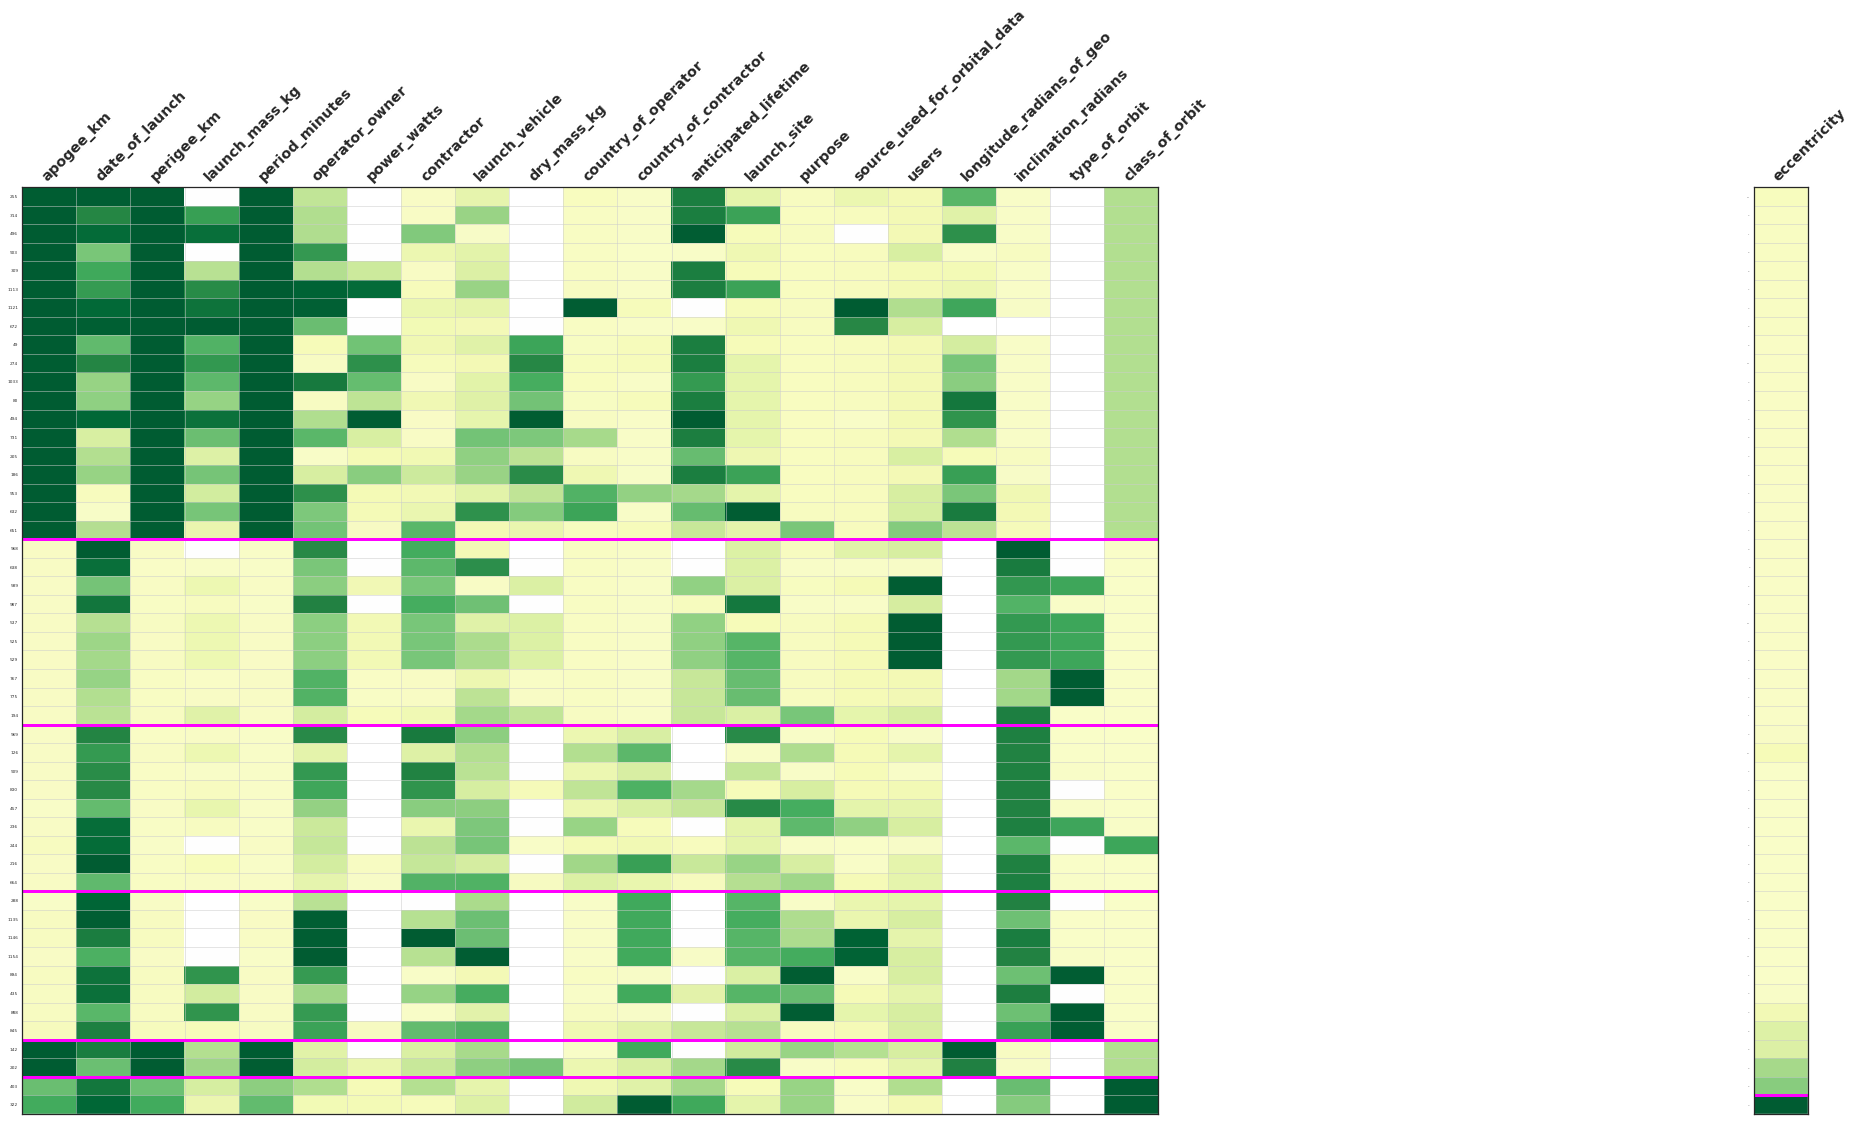

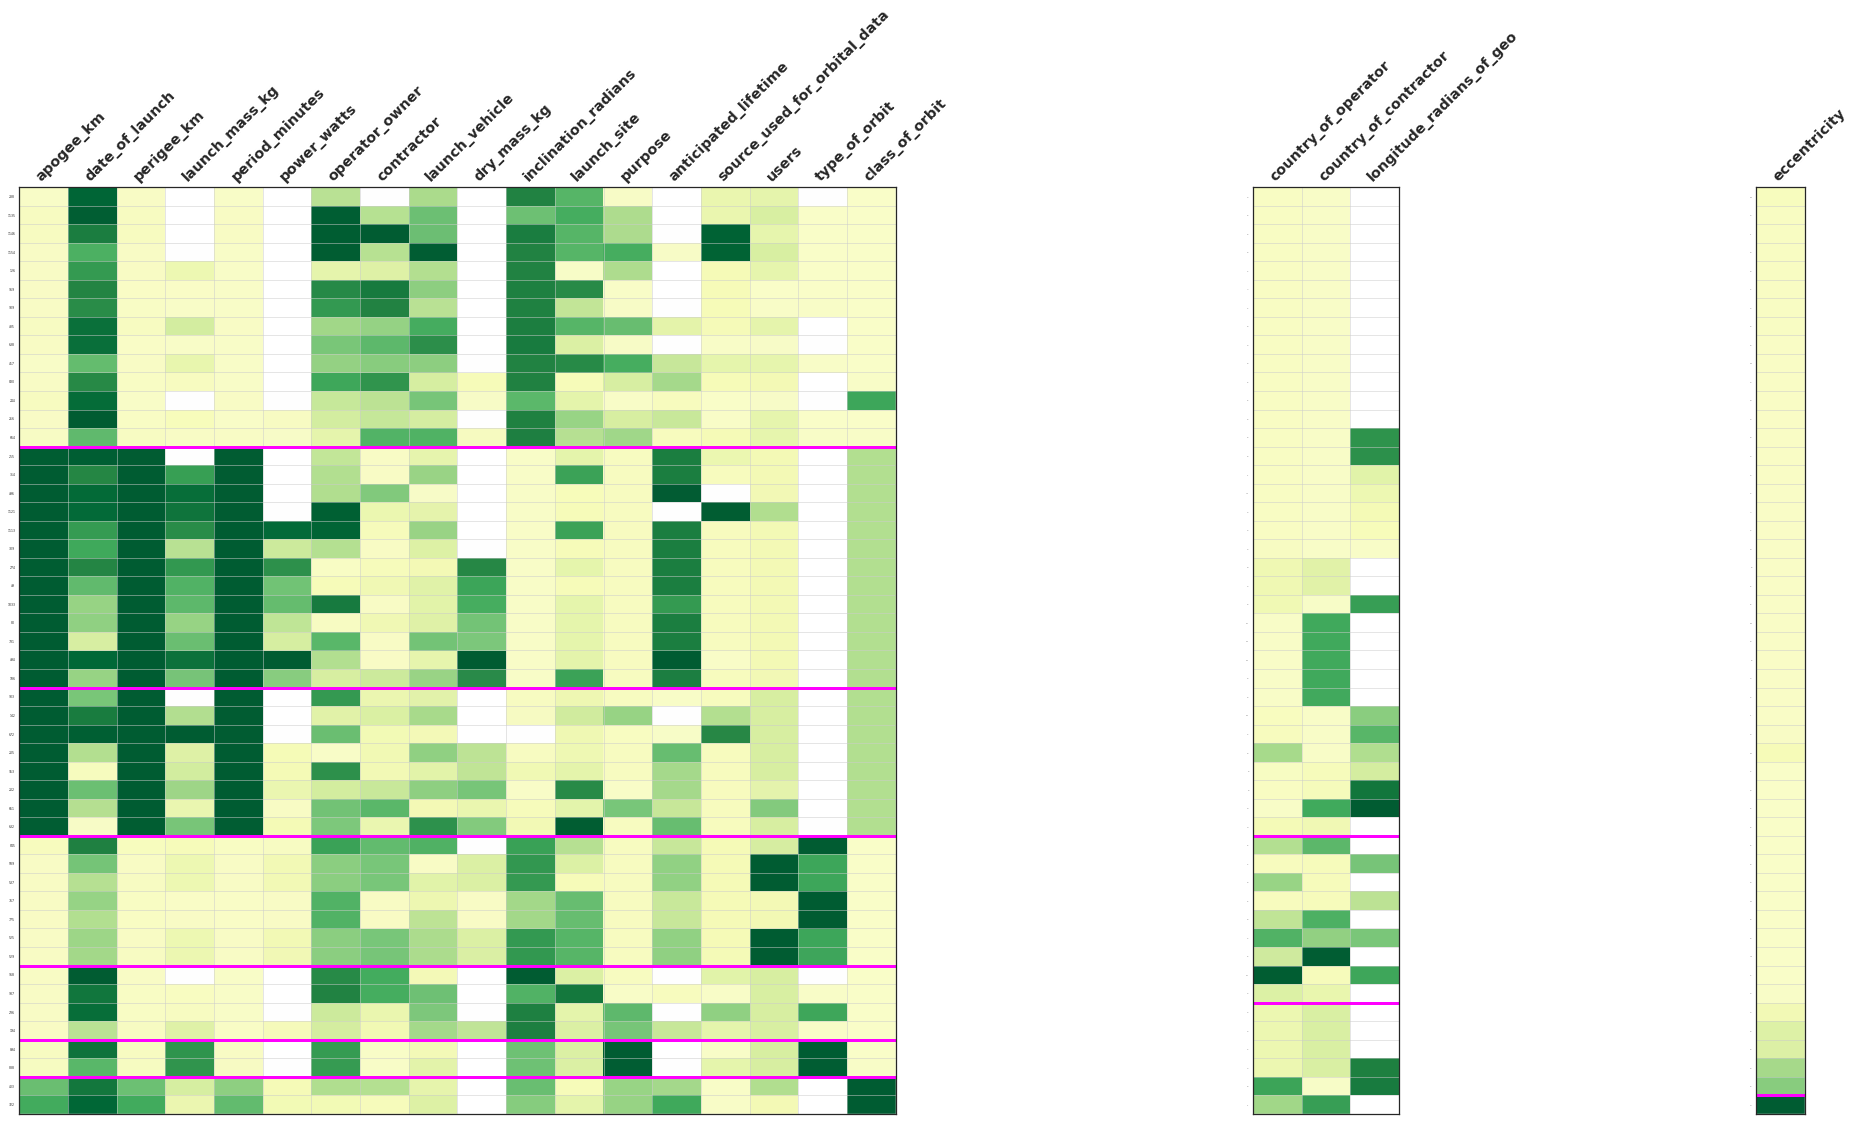

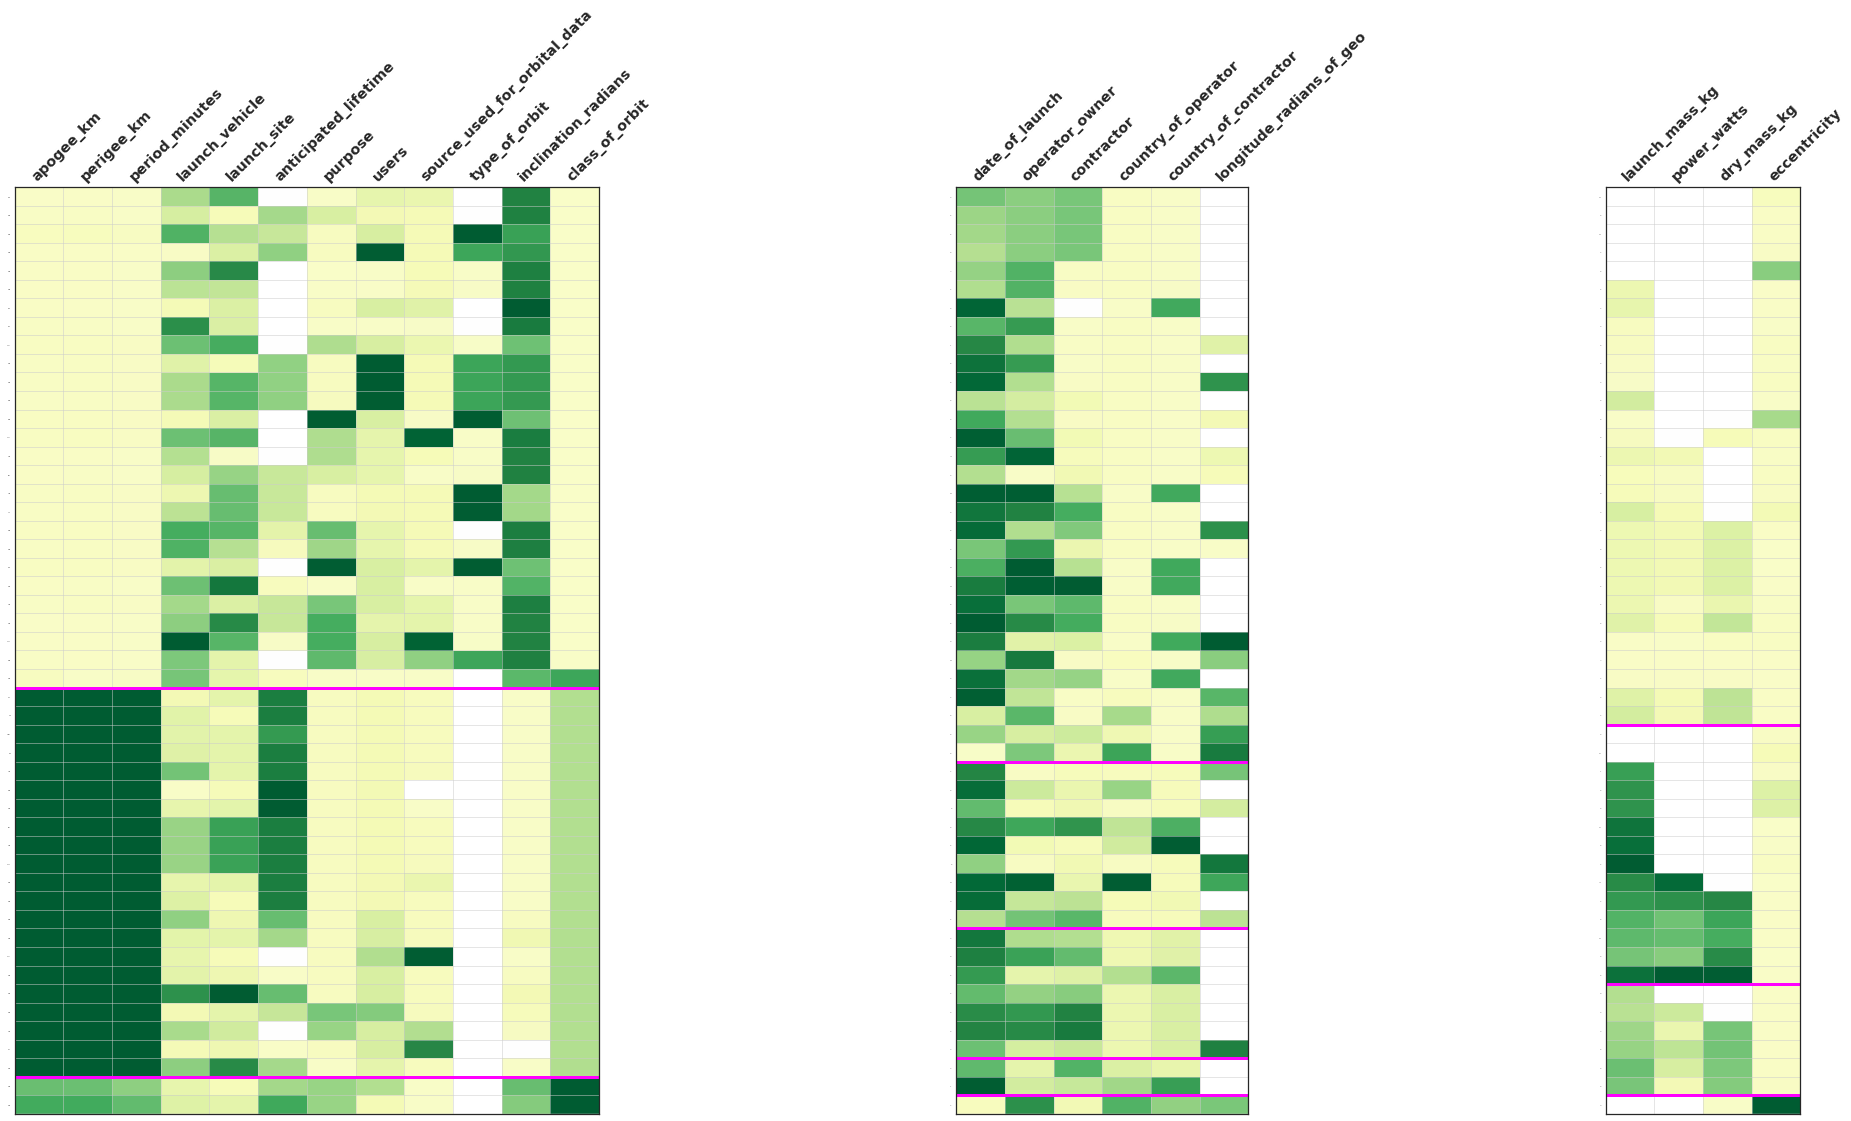

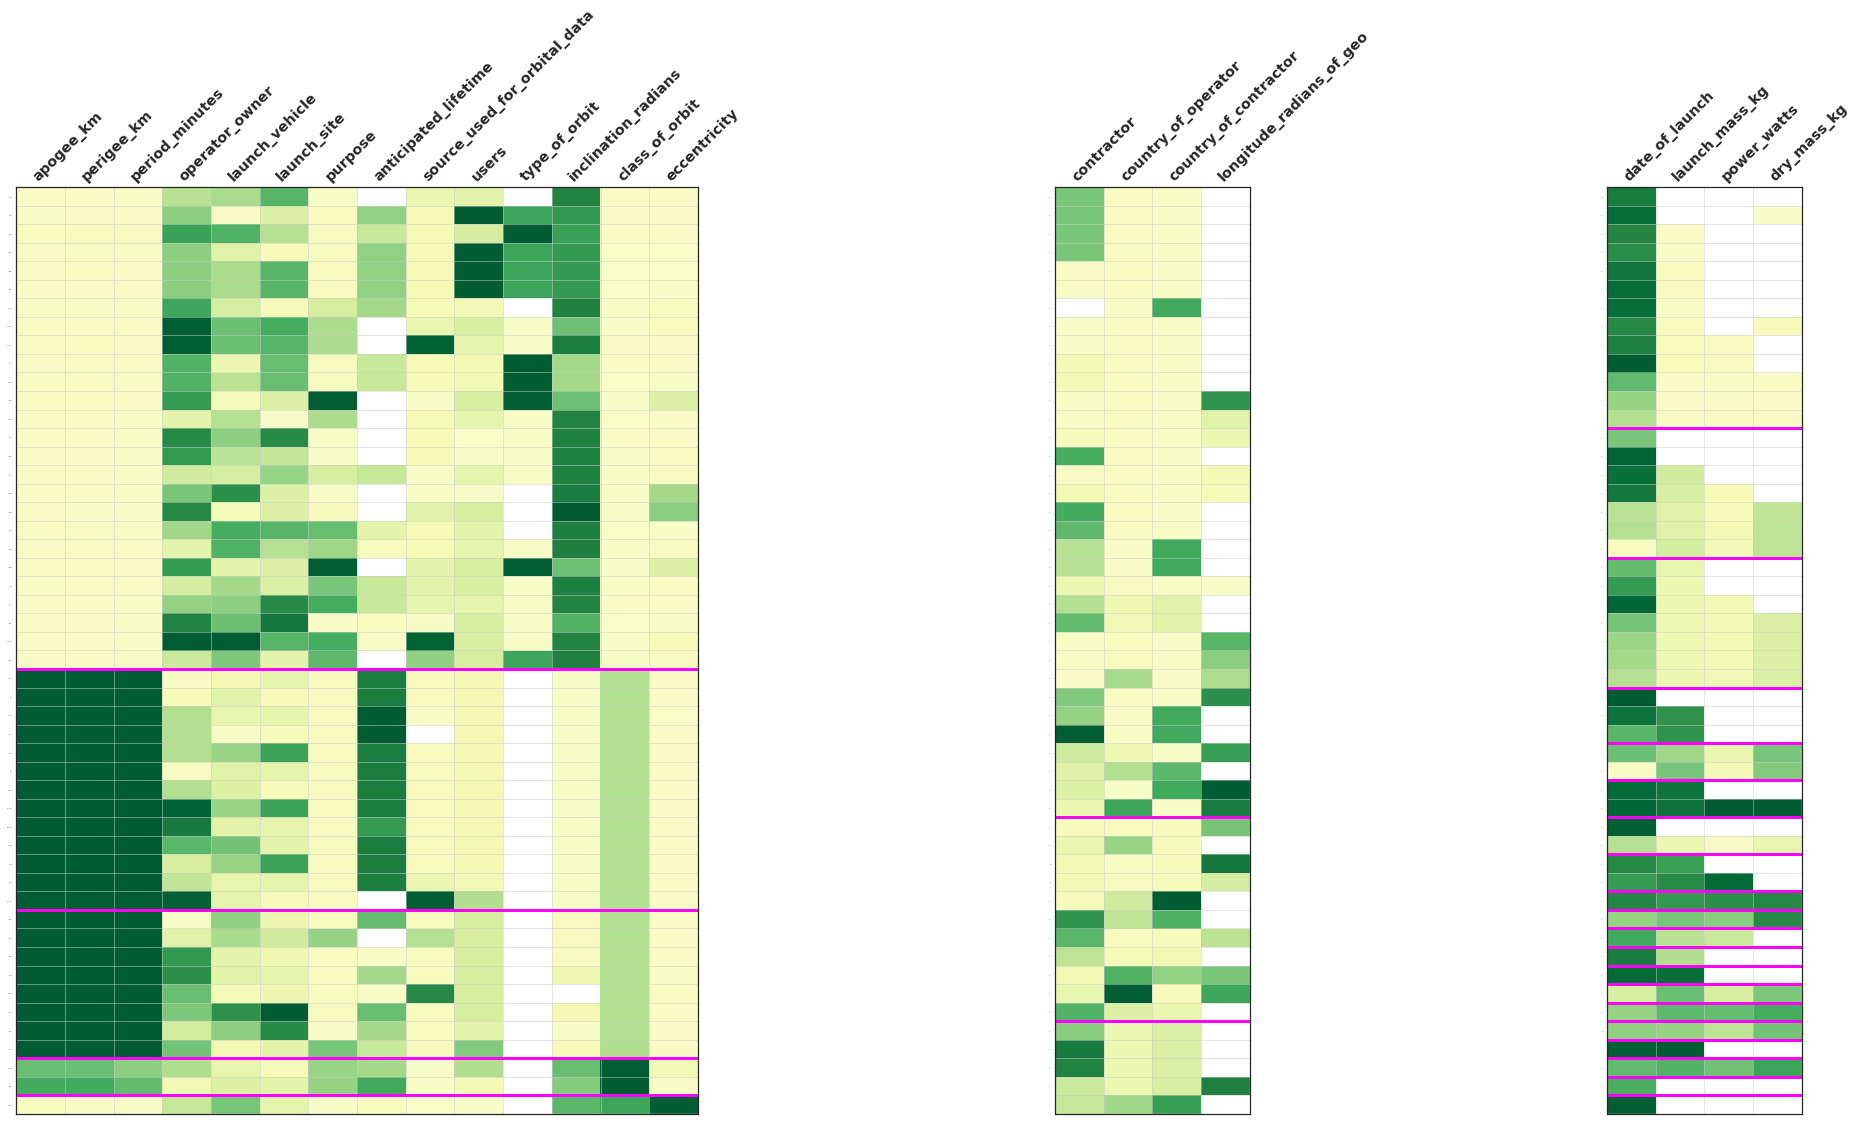

In [12]:
%mml .render_crosscat --subsample=50 satellites_crosscat 0
%mml .render_crosscat --subsample=50 satellites_crosscat 3
%mml .render_crosscat --subsample=50 satellites_crosscat 5
%mml .render_crosscat --subsample=50 satellites_crosscat 7

### Finding satellite characteristics which are probably dependent on one another

Let us look at a dependence heatmap for the satellites variables. Each row and column in the heatmap is a variable in the population, and the color of a cell indicates the posterior probability (a value between 0 and 1) that there exists some dependence between those two variables.

In [13]:
%bql .interactive_heatmap ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE VARIABLES OF satellites;

<IPython.core.display.Javascript object>

We can compare the probable dependencies detected by CrossCat to the pairwise linear correlations between variables
(Pearson R for `NUMERICAL-NUMERICAL`, Cramer's Phi for `NOMINAL-NOMINAL`, and `ANOVA R` for `NUMERICAL-NOMINAL`).
In the heatmap below, we are showing only correlations which are significant at the 0.01 level (i.e. without Bonferroni correction). The correlation values which are not statistically significant are shown in gray. 

In [14]:
%bql .interactive_heatmap ESTIMATE CORRELATION FROM PAIRWISE VARIABLES OF satellites WHERE CORRELATION PVALUE < 0.01;

<IPython.core.display.Javascript object>

How does the correlation map differ from the dependence probability heatmap from CrossCat? There are several variables which CrossCat detects as probably dependent, such as `power_watts` and `perigee_km`, that match our common sense expectations and observed patterns from the pairwise scatter plots, but have very low or statistically insignifcant Pearson correlations. Can you find more pairs of such variables? Why do you think these relationships are missed by Pearson R? Refer back or create new pairplots to answer these questions.

### Generating hypothetical satellites: comparing SQL `SELECT` to BQL `SIMULATE` for country--purpose

Recall that CrossCat learns a full generative for all variables in the database __jointly__. By having a generative model, we can use BQL `SIMULATE` to generate _hypothetical_ satellites, possibly conditioned on some user-specified features. In this section, we will explore the BQL `SIMULATE` query, and compare the distributions from satellite simulations to the actual (empirical) distributions in the `satellites_t` table.

We are going to compare simulations from the joint distribution of `country_of_operator` and `purpose` to selections from the data table. Let us first create a table named `country_purpose_top10` which contains the top-10 most frequent country-purpose pairs.

In [15]:
%%bql
CREATE TEMP TABLE country_purpose_top10 AS
SELECT
    country_purpose,
    COUNT(country_purpose) AS count
FROM (
    SELECT country_of_operator ||'--'|| purpose AS country_purpose
    FROM satellites_t)
GROUP BY country_purpose
ORDER BY count DESC
LIMIT 10

""


The most frequently occurring country-purpose pairs are `USA--Communications` and `Russia--Communications`, with 304 and 56 satellites, respectively. Marginally, `Communications` seems to be the most frequent `purpose`, and `USA` the most frequent country.

In [16]:
%bql SELECT * FROM country_purpose_top10

,country_purpose,count
0,USA--Communications,304
1,Russia--Communications,56
2,USA--Technology Development,54
3,Multinational--Communications,39
4,USA--Navigation/Global Positioning,32
5,China (PR)--Remote Sensing,31
6,Russia--Navigation/Global Positioning,31
7,China (PR)--Communications,24
8,United Kingdom--Communications,22
9,Luxembourg--Communications,17


The following query selects all rows `satellites_t` whose `country_of_operator` and `purpose` are in the top 10 table that we just created.

In [17]:
%%bql
CREATE TEMP TABLE selections AS
SELECT country_of_operator || '--' || purpose AS country_purpose
FROM satellites_t
WHERE country_purpose IN (
    SELECT country_purpose FROM country_purpose_top10
);

""


Now we are going to use the BQL `SIMULATE` query to generate 1000 simulations from CrossCat's learned joint distribution of `country_of_operator` and `purpose`. This query appears as a subexpression after the `FROM` keyword.
From these simulations, we are going to again select records whose simulated `country_of_operator` and `purpose` are in the top 10 table, and store the results in a table named `simulations`.

In [18]:
%%bql
CREATE TEMP TABLE simulations AS
SELECT country_of_operator || '--' || purpose AS country_purpose
FROM (
    SIMULATE
        country_of_operator,
        purpose
    FROM satellites
    LIMIT 1000
)
WHERE country_purpose IN (
    SELECT country_purpose FROM country_purpose_top10
);

""


A common model-checking technique in probabilistic data analysis is comparing the posterior simulations to empirical data. This check gives us insight into how well the data generator fits the existing data, and whether it is able to recover marginal, joint, and conditional distributions. In the next cell, we are going to show a normalized histogram of the records in `selections` and compare them to those in `simulations`. We can therefore compare the posterior distribution to the data, and check visually how well they match.

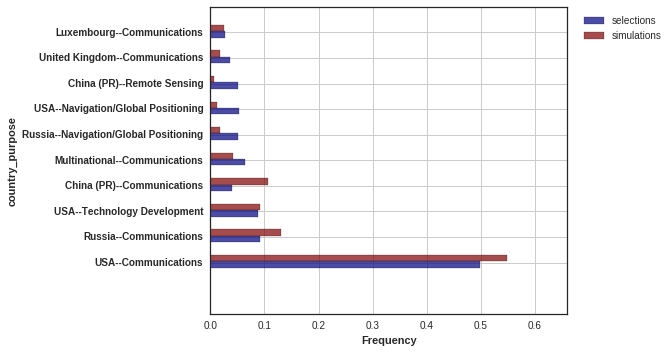

In [19]:
%%sql
.histogram_nominal --normed=True
SELECT
    country_purpose, 'selections'
FROM selections
UNION ALL
SELECT
    country_purpose, 'simulations'
FROM simulations;

The above histogram shows that the `simulations` from CrossCat's posterior distribution correctly capture the `USA--Communications` mode (with a slight overshoot). It also recovers the relative orderings of the rest of the top 8, except for switching `China (PR)--communications` and `Multinational--Communications`. The histogram confirms that several characteristics of the joint distribution are learned by CrossCat.

To iterate and refine the quality of the simulations indicated by this plot, we can regenerate it using more samples (we used `LIMIT 1000` in the BQL `SIMULATE` query, and then subselected from those). We could also produce several versions of the plot, varying the number of `ANALYZE` iterations or amount of time, and view the evolution of the model fit.

### Modeling mechanistic dependencies using Kepler's Third Law and custom probabilistic programs

Three variables in the `satellites` population have a physical (mechanistic) relationship specified by Kepler's third law of planetary motion. A simple introduction can be found [here (scroll down for an image after the equations)](https://www.orbiter-forum.com/showthread.php?t=26682). Briefly, these variables are `apogee_km` (A), `perigee_km` (P), and `period_minutes` (T), which are related by the equation:

$$
T = 2\pi\sqrt{\frac{(A+P)^3}{8GM}},
$$

where $G$ and $M$ are physical constants. In this section, we will first investigate the Keplerian dynamics in the data and check which satellites deviate from the expected behavior. We then integrate domain knowledge about Kepler's law into our probabilistic modeling of satellites.

Let us first explore the empirical distribution of `perigee_km`, by using the `.density` plotting magic. Note that `--xmin` and `--xmax` are used to the set the limits of the plot.

### Comparing marginal distributions using `SELECT` and `SIMULATE`

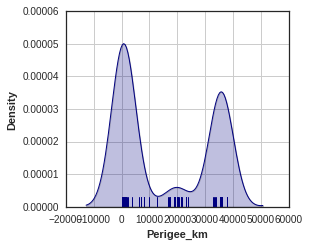

In [20]:
%bql .density --xmin=-20000 --xmax=60000 SELECT perigee_km FROM satellites_t;

There is a clear multi-modality in the distribution of `perigee_km`, a large mode near ~100 kilometers, a small mode near 20000 kilometers, and a large mode near 40000 kilometers. Let use the `SIMULATE` query again to check whether the CrossCat analysis has recovered this multi-modal pattern

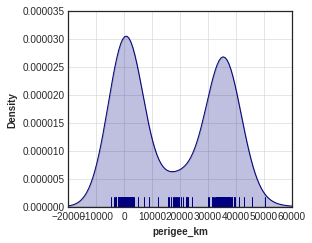

In [21]:
%bql .density --xmin=-20000 --xmax=60000 SIMULATE perigee_km FROM satellites LIMIT 250;

The modes from the simulated data largely agree with the empirical modes, although observe that, under each mode, the simulated distribution has wider tails than those of the empirical distributions.

Let us do a SQL `SELECT` on `period_minutes` to view its empirical distribution.

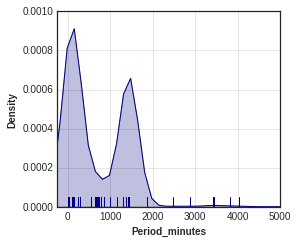

In [22]:
%bql .density --xmin=-250 --xmax=5000 SELECT period_minutes FROM satellites_t;

The distribution of `period_minutes` also has two main modes, and a smaller mode in the right tail (is this finding surprising? Recall the mechanistic relationship between `perigee_km` and `period_minutes` from Kepler's third law). Let us compare the CrossCat simulations to check model fit. 

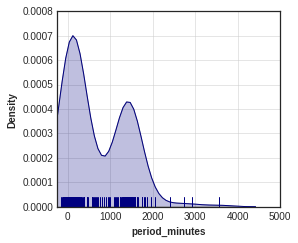

In [23]:
%bql .density --xmin=-250 --xmax=5000 SIMULATE period_minutes FROM satellites LIMIT 250;

It seems that the marginal distribution from CrossCat `SIMULATE` also agrees with the empirical marginal, including the weak mode in the tail.

We now move from plotting the marginals to studying the _joint_ distribution of `period_minutes` and `perigee_km`.

### Finding satellites with anomalous orbital periods

To produce scatter plots we use the `.scatter` plotting magic, where the third column (`class_of_orbit`) specified by the query will be used as a label to color the points in the legend. How does the joint distribution vary with a satellite's orbit class? Does it make sense that satellites in `LEO` (low earth orbit) have smaller periods and perigees than satellites in `MEO` (medium earth orbit)?

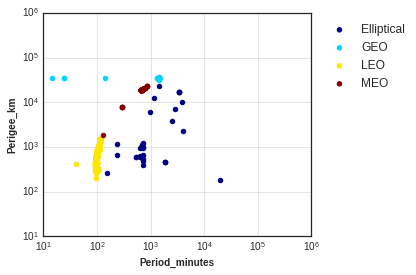

In [24]:
%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SELECT period_minutes, perigee_km, class_of_orbit FROM satellites_t;

Looking at the scatter plot, there appear to be some satellites that do not follow the same behavior as their class. We can find probable anomalies in BayesDB using the BQL `PREDICTIVE PROBABILITY` query. Recall that, since CrossCat learns a the joint distribution over all variables in the dataset, for each satellite we can ask for the probability of having observed its value for `period_minutes` (more particularly, we can ask "for a satellite X, what is the probability of observing a new satellite Y which has the same period as that of X?).

In the next query, we iterate through each satellite in the population and select only those satellites for which the _marginal probability_ of observing its `period_minutes` is greater than the _conditional probability_ of the `period_minutes`, given its `apogee_km` and `perigee_km`. In particular, what this query is finding satellites which have an unlikely period after we are told about its apogee and perigee.

We will turn off multiprocessing analysis for this query (it will take roughly 1.5 minutes to run to completion).

In [25]:
%multiprocess off

Multiprocessing turned off from on.


In [26]:
%%bql
ESTIMATE
    "name",
    "apogee_km",
    "perigee_km",
    "class_of_orbit",
    "period_minutes"
FROM satellites
WHERE (
    PREDICTIVE PROBABILITY OF period_minutes
    > PREDICTIVE PROBABILITY OF period_minutes GIVEN ("apogee_km", "perigee_km")
)

,Name,Apogee_km,Perigee_km,Class_of_Orbit,Period_minutes
0,"Advanced Orion 6 (NRO L-15, USA 237)",35805,35771,GEO,23.94
1,DSP 20 (USA 149) (Defense Support Program),35909,35897,GEO,142.08
2,Intelsat 903,358802,35773,GEO,1436.16
3,"SDS III-6 (Satellite Data System) NRO L-27, Gr...",35803,35770,GEO,14.36
4,"SDS III-7 (Satellite Data System) NRO L-38, Dr...",35805,35771,GEO,23.94
5,Sirius 1 (SD Radio 1),47100,23783,Elliptical,1418.50


Let's look at each of the possible anomalies and try to explain each one.

- `Advanced Orion 6` and `SDS III-7`: These satellites are in `GEO` orbit, but have recorded periods of 23.94 minutes, which is absurd! Perhaps the intention was to be 23.94 _hours_, which is roughly 1436 minutes for a typical `GEO` satellite. CrossCat has found an __error in the units__.

- `DSP 20` and `SDS III-6`: These satellite is also in `GEO` orbit but have recorded periods of 142.08 and 14.36. The best explanation is that these are __decimal-place errors__.

- `Intelsat 903`: This satellite has an enormous `apogee_km` of 358,802. According to Kepler's Law, it should have a period of ~15245 minutes. Either the database has an error in the reported period of 1536.16, or the `apogee_km` is supposed to instead be 35,880.2 km (which would be the typical value for a `GEO` satellite).

We emphasize that the baseline CrossCat analysis __does not__ encode our domain knowledge from Kepler's law (we will work on this extension shortly). CrossCat is a model building and discovery engine which is based on learning non-parameteric multivariate mixtures.

These errors have been reported to the maintainers of the database.

### Building a custom probabilistic program for Kepler's third law

Even though CrossCat succesfully found several data entry errors and other anomalies, it does not know about Kepler's third law of motion. Let us compare `SELECT` and `SIMUALTE` for the joint distribution of `period_minutes`, `perigee_km` and `class_of_orbit` to get a sense about how CrossCat models joint distributions, and how well it matches Kepler's law. The top plot shows the results of `SELECT`, and the lower plot shows the results of `SIMULATE`.

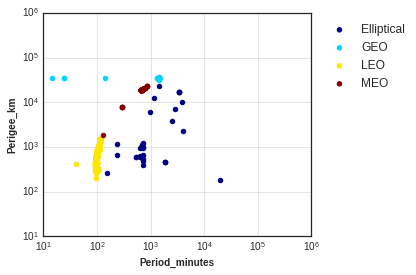

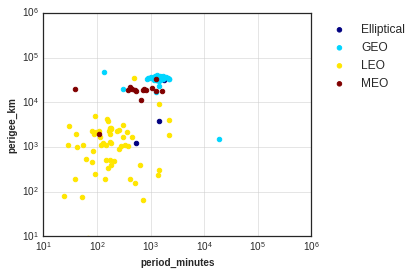

In [27]:
%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SELECT period_minutes, perigee_km, class_of_orbit FROM satellites_t;

%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SIMULATE period_minutes, perigee_km, class_of_orbit FROM satellites LIMIT 250;

Even though simulations from Crosscat capture the correct _qualitative_ behavior of the joint distribution (you should verify that the shape of the curve from `SIMULATE` is the same as the shape from `SELECT`), there is significant over-dispersion in the simulations (particularly for `LEO` and `MEO` satellites). While the `SELECT` appears to show a non-linear but slightly noisy deterministic curve for all but `Elliptical` satellites, the noise from CrossCat is much higher.

In this phase of the tutorial, we are going to use `Venture` to `OVERRIDE` the default crosscat baseline analysis for the conditional distribution of `period_minutes` given `apogee_km` and `perigee_km`. Recall that the deterministic relationship is:

$$
T = \textrm{Kepler}(A,P) = 2\pi\sqrt{\frac{(A+P)^3}{8GM}}.
$$

We saw, however, that in practice (i) there is some noise in the value of the period, and (ii) some satellites are outliers. We are going to therfore write a stochastic variant of Kepler's law using the following generative model:

$$
p_{\rm outlier} \sim {\rm Beta}(2,5) \\
$$

$$
\epsilon_{\rm inlier} = {\rm NIG-Normal}(1,1,1,1)\\
\epsilon_{\rm outlier} = {\rm NIG-Normal}(1,1,1,1)\\
$$

$$
{\rm outlier}_i \sim {\rm Bernoulli}(p_{\rm outlier}) \\
T_i \sim \textrm{Kepler}(A,P) + \begin{cases}
    \epsilon_{\rm inlier} && \textrm{if } \rm{outlier}_i = 0\\
    \epsilon_{\rm outlier} && \textrm{if } \rm{outlier}_i = 1
\end{cases}.
$$

In words, $p_{\rm outlier}$ is the probability a particular satelite is an outlier; ${\rm outlier}_i$ is 1 if satellite $i$ is an outlier, and 0 otherwise; $T_i$ is the period of satellite $i$, and $\epsilon_{\rm outlier}, \epsilon_{\rm inlier}$ are the error distributions for outliers and inliers, respectively. We expect the error distribution for outliers takes value that are much larger than that of the inlier error distribution. These error values will be largely determined by the sufficient statistics of the satellites in each of the two clusters.

Let us first express the above generative model using Venture.

In [28]:
%%venturescript
// Kepler CGPM.
define kepler = () -> {

  // Kepler's law.
  assume keplers_law = (apogee, perigee) -> {
    let GM = 398600.4418;
    let earth_radius = 6378;
    let a = (abs(apogee) + abs(perigee)) *
        0.5 + earth_radius;
    2 * 3.14159265359 * sqrt(a**3 / GM) / 60
  };

  // Internal samplers.
  assume outlier_prob = beta(2,5);
  assume error_sampler = mem((is_outlier) -> {
    make_nig_normal(1, 1, 1, 1)
  });

  // Output simulators.
  assume sim_is_outlier = mem((rowid, apogee, perigee) ~> {
      flip(outlier_prob) #latent:rowid
  });

  assume sim_period_error = mem((rowid, apogee, perigee) ~> {
      let is_outlier = sim_is_outlier(rowid, apogee, perigee);
      error_sampler(is_outlier)() #latent:rowid
  });

  assume sim_period = mem((rowid, apogee, perigee) ~> {
      keplers_law(apogee, perigee) + sim_period_error(rowid, apogee, perigee)
  });

  // List of simulators.
  assume simulators = [sim_period, sim_is_outlier, sim_period_error];
};

// Output observers.
define obs_is_outlier = (rowid, apogee, perigee, value, label) -> {
    $label: observe sim_is_outlier($rowid, $apogee, $perigee) = atom(value);
};
define obs_period_error = (rowid, apogee, perigee, value, label) -> {
    $label: observe sim_period_error( $rowid, $apogee, $perigee) = value;
};
define obs_period = (rowid, apogee, perigee, value, label) -> {
    let theoretical_period = run(sample keplers_law($apogee, $perigee));
    obs_period_error(rowid, apogee, perigee, value - theoretical_period, label);
};

// List of observers.
define observers = [obs_period, obs_is_outlier, obs_period_error];

// List of inputs.
define inputs = ["apogee", "perigee"];

// Transition operator.
define transition = (N) -> {mh(default, one, N)};

Now that we have defined our generative model, we are going to create a new `GENERATOR` named `satellites_crosscat_kepler`. This generator is still based on the `crosscat` baseline, except it will `OVERRIDE`  the generative model for (`period_minutes` GIVEN `apogee_km` and `perigee_km`) using the Venture model for stochastic Kepler defined in the previous cell. We are also going to base our analysis on a subsample of 250 satellites.

A full description of the formalism for composing analysis in the manner shown below can be found in:

> _A Probabilistic Programming Approach To Probabilistic Data Analysis_. Saad, F.; and Mansinghka, V. In Advances in Neural Information Processing Systems (NIPS). 2016. [Conference version](https://papers.nips.cc/paper/6060-a-probabilistic-programming-approach-to-probabilistic-data-analysis.pdf), [Journal version](https://arxiv.org/abs/1608.05347).

In this tutorial, we only outline the very basics declaring generators with custom modeling strategies.

In [29]:
%%mml
CREATE GENERATOR satellites_crosscat_kepler FOR satellites (

    OVERRIDE GENERATIVE MODEL
    FOR
        period_minutes
    GIVEN
        apogee_km, perigee_km
    AND EXPOSE
        kepler_cluster NOMINAL,
        kepler_residual NUMERICAL
    USING
    venturescript(mode=venture_script, sp=kepler);

    SUBSAMPLE 250
)

""


Observe that the `satellites_crosscat_kepler` is also defined for the `satellites` population, just like the `satellites_crosscat` generator. In general, BayesDB allows a single population to have many different generators. We will show how a user can specify which generator to use for a query about a population, or tell BayesDB to aggregate across all generators to answer a BQL query.

We will base our inference using 1 model, rather than an ensemble.

In [30]:
%mml INITIALIZE 1 MODEL FOR satellites_crosscat_kepler

""


The next two cells dispatch analysis. Note that we are using special MML keywords in `ANALYZE` named `VARIABLES` and `SKIP` in the first and second cells, respectively. The `VARIABLE` keyword tells the `satellites_crosscat_kepler` to run analysis on the specified variables, and `SKIP` will run analysis on all variables execpt for the specified variables.

Recall that we overrode CrossCat for `period_minutes`, so the first cell is running analysis in Venture, and the second `ANALYZE` cell is running analysis using CrossCat.

In [31]:
%%mml
ANALYZE satellites_crosscat_kepler FOR 750 ITERATIONS (
    VARIABLES period_minutes, kepler_cluster, kepler_residual;
)

Completed: 750 iterations in 9.945128 seconds.


""


In [32]:
%%mml
ANALYZE satellites_crosscat_kepler FOR 1 MINUTE (
    SKIP period_minutes, kepler_cluster, kepler_residual;
    OPTIMIZED
)

Completed: 920 iterations in 60.008718 seconds.


""


Now that we have run analysis, let us go back to our comparisons of `SELECT` versus `SIMULATE` using (i) `satellites_crosscat`, the baseline generator, and (ii) `satellites_crosscat_kepler`, the generator that includes our custom generative model for the period. These three scatter plots are shown below.

These queries use the `SIMULATE <variables> FROM <population> MODELED BY <analysis_schema>` syntax, which tells BayesDB which generator to use for generating simulations of the requested variables. We can also avoid using the `MODELED BY` phrase, which will tell BayesDB to generate samples using a combination of all generators for the population.

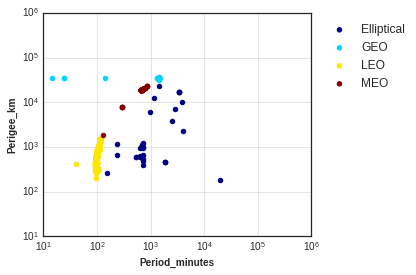

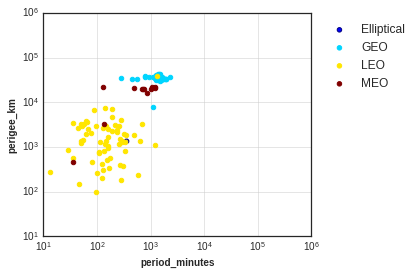

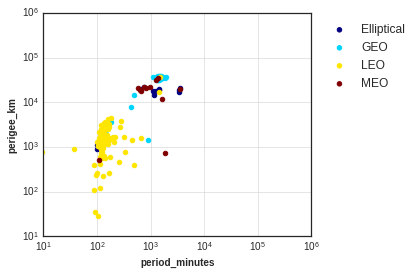

In [33]:
%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SELECT period_minutes, perigee_km, class_of_orbit \
    FROM satellites_t;
    
%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SIMULATE period_minutes, perigee_km, class_of_orbit \
    FROM satellites MODELED BY satellites_crosscat LIMIT 250;

%bql .scatter --ymin=1e1 --ymax=1e6 --xmin=1e1 --xmax=1e6 --xlog=10 --ylog=10 \
    SIMULATE period_minutes, perigee_km, class_of_orbit \
    FROM satellites MODELED BY satellites_crosscat_kepler LIMIT 250;

We notice that the simulations from `satellites_crosscat_kepler` are more representative of the non-linear curve from Kepler's law than are the noisy simulations from `satellites_crosscat`.

Note that, the `satellites_crosscat_kepler` is a _composition_ of CrossCat and our Kepler model --- in particular, the simulations of `perigee_km` and `class_of_orbit` (and `apogee_km` which is implicitly simulated) in the final plot are generated using CrossCat, which are then given to the Kepler model to produce the the simulation of `period_minutes`.

This type of extensible modeling is a key component of BayesDB, where CrossCat can be used as a model building and disovery engine for baseline queries, and then domain-specific knowledge can be expressed using custom programs (such as the stochastic Kepler model) that override CrossCat and result in refined models of the data.